In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

import math, copy, time
import os
import pandas as pd
import torchinfo

import matplotlib.pyplot as plt
%matplotlib inline

import data_valuator
import funtions_for_dvrl

## Import Data

In [56]:
x = torch.tensor([2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19, 20, 18, 17, 15, 14, 12, 11, 9, 8, 6, 5, 3, 2, 0, 1]).view(27,1)
y = torch.tensor([1]).view(1,1)
for i in range(100):
    y = torch.cat((y,x), dim=0)

for j in range(2):
    y = torch.cat((y,y), dim=1)

y.shape

torch.Size([2701, 4])

In [57]:
dataset2 = y.numpy().astype(np.float64)
print(f"Shape : {dataset2.shape}, Data Type : {dataset2.dtype}")

Shape : (2701, 4), Data Type : float64


<function matplotlib.pyplot.show(close=None, block=None)>

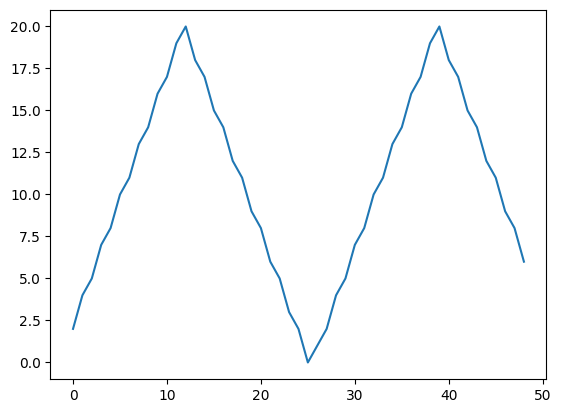

In [58]:
plt.plot(dataset2[1:50,2])
plt.show

## Corrupt Data

<function matplotlib.pyplot.show(close=None, block=None)>

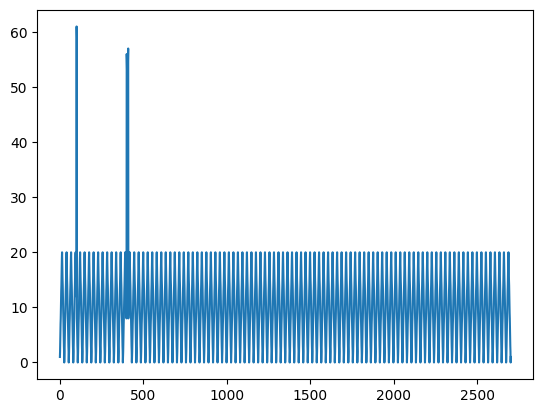

In [59]:
dataset2[100:102] += 50
dataset2[400:410] += 50
plt.plot(dataset2[:,2])
plt.show

## Convert Data Shape

In [60]:
train_split = 1000
lookback = 5
lookahead = 2
step = 1
batch_size = 45

x_train_multi, y_train_multi = funtions_for_dvrl.multivariate_data(dataset2, dataset2, 0,
                                                 train_split, lookback,
                                                 lookahead, step)
x_val_multi, y_val_multi = funtions_for_dvrl.multivariate_data(dataset2, dataset2,
                                             train_split, 1500, lookback,
                                             lookahead, step)

print (x_train_multi.shape,
       y_train_multi.shape,
       'Input size : {}'.format(x_train_multi[0].shape),
       'Target size to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

(995, 5, 4)
(995, 2, 4)
Input size : (5, 4)
Target size to predict : (2, 4)


In [61]:
#Extracting a single column for univariante time series
x_train = torch.from_numpy(x_train_multi[:,:,2])
y_train = torch.from_numpy(y_train_multi[:,:,2])
x_valid = torch.from_numpy(x_val_multi[1:100,:,2])
y_valid = torch.from_numpy(y_val_multi[1:100,:,2])

x_valid = torch.unsqueeze(x_valid,2)
x_valid = x_valid.transpose(1,0).float()

y_valid = torch.unsqueeze(y_valid,2)
y_valid = y_valid.transpose(1,0).float()
print(f"X Train Shape : {x_train.shape}")
print(f"Y Train Shape : {y_train.shape}")
print(f"X Valid Shape : {x_valid.shape}")
print(f"Y Valid Shape : {y_valid.shape}")

X Train Shape : torch.Size([995, 5])
Y Train Shape : torch.Size([995, 2])
X Valid Shape : torch.Size([5, 99, 1])
Y Valid Shape : torch.Size([2, 99, 1])


### Load Model

In [62]:
def make_model(lookback = lookback, lookahead = lookahead, datavaluator_hidden = 64):
    "Helper: Construct a model from hyperparameters."
    #c = copy.deepcopy
    #data_valuator_mlp = Data_Valuator_MLP(lookback+lookahead, datavaluator_hidden)

    model_1 = data_valuator.Data_Valuator_MLP(lookback+lookahead, datavaluator_hidden)

    return model_1

In [63]:
model_1 = make_model()

checkpoint = torch.load('C:/Users/poops/Desktop/Coding Shenanigans/RnDProject/plswork/data_valuator.pth')
model_1.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['num_of_epochs']
loss = checkpoint['final_reward']

In [64]:
data_values = torch.zeros_like(x_train)[:,0].view(len(x_train),1)
data_values.shape

torch.Size([995, 1])

In [65]:
time_window_size = 45
with torch.no_grad():
    for T in range(10000):
        #Make Time Window Batches
        if T == 980:
            break
        x_batch, y_batch = funtions_for_dvrl.MovingBatch(x_train, y_train, time_window_size, T)
        #Pass Throught Data Valuator MLP
        input = torch.cat((x_batch,y_batch), 1)
        prob_vector = model_1.forward(input)
        data_values[T:len(x_batch)+T]= data_values[T:len(x_batch)+T] + prob_vector

In [67]:
data_values[90:140]

tensor([[23.8790],
        [23.9513],
        [24.0087],
        [23.9168],
        [22.9185],
        [22.8800],
        [24.6250],
        [25.6566],
        [25.7437],
        [24.9722],
        [23.7643],
        [23.3893],
        [22.5818],
        [22.4002],
        [22.2202],
        [22.1423],
        [22.2205],
        [22.3159],
        [22.4031],
        [22.5037],
        [22.6538],
        [22.8010],
        [22.9792],
        [23.1120],
        [23.3271],
        [23.4603],
        [23.6450],
        [23.8790],
        [23.9513],
        [24.0087],
        [23.9168],
        [23.8895],
        [23.6554],
        [23.5701],
        [23.3303],
        [23.2318],
        [22.9620],
        [22.8865],
        [22.5700],
        [22.5818],
        [22.4002],
        [22.2202],
        [22.1423],
        [22.2205],
        [22.3159],
        [22.4031],
        [22.5037],
        [22.6538],
        [22.8010],
        [22.9792]], dtype=torch.float64)